In [249]:
import lyricsgenius
import pandas as pd
import time
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

genius = lyricsgenius.Genius('mBsskYOT8SF3neo23GKqXRA3zGO0WAxcSHjti3QHaA_rPJtS3IKhhLcXz-yN5Xxe')


from datamuse import datamuse
api = datamuse.Datamuse()

In [259]:
#Testing whether the lyricsgenius module works
artist = genius.search_artist("Drake", max_songs=3, sort="popularity")
print(artist.songs)


Searching for songs by Drake...

Song 1: "God’s Plan"
Song 2: "In My Feelings"
Song 3: "Hotline Bling"

Reached user-specified song limit (3).
Done. Found 3 songs.
[Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...)]


# Trying to use the NLTK CMU pronounciation corpus to determine rhyme


Huge thanks to Ouflak from: https://stackoverflow.com/questions/25714531/find-rhyme-using-nltk-in-python/39312114

In [2]:
# global
import json

json_entries = None

def tup2dict(tup, di):
    for a, b in tup:
        di.setdefault(a, []).append(b)
    return di

In [17]:
import nltk

nltk.download('cmudict')
nltk.corpus.cmudict.ensure_loaded()
cmu_entries = nltk.corpus.cmudict.entries()
cmu_dict = dict()
tup2dict(cmu_entries, cmu_dict)
with open('./cmu.json', 'w') as convert_file:
    convert_file.write(json.dumps(cmu_dict))

[nltk_data] Downloading package cmudict to
[nltk_data]     C:\Users\Fuaad\AppData\Roaming\nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


In [3]:
def require_rhyme_dict():
    global json_entries
    if json_entries:
        return
    try:
        jsonf = open('./cmu.json', 'r')
    except:
        pass
    else:
        # Global
        json_entries = dict(json.load(jsonf))
        jsonf.close()
        print('json_entries loaded.')

In [4]:
require_rhyme_dict()

json_entries loaded.


In [5]:
def isRhyme(row):
    require_rhyme_dict()
    global json_entries
    word1_syllable_arrs = json_entries.get(row.word1)
    word2_syllables_arrs = json_entries.get(row.word2)
    if not word1_syllable_arrs or not word2_syllables_arrs:
        return False
    for a in word1_syllable_arrs:
        for b in word2_syllables_arrs:
            if a[-2:] == b[-2:]:
                return True
    return False

In [295]:
json_entries.get('chopra')

[['CH', 'AA1', 'P', 'R', 'AH0']]

In [294]:
#Test dataframe
data = {'word1': ['october', 'forest', 'inspire', 'medication'], 
        'word2': ['chopra', 'august', 'meditation','meditation']}  
  
# Create DataFrame  
df = pd.DataFrame(data) 

#Now let's see if the words in the first row (word1) rhyme with their counterparts below (word2)
for i in range(len(df)):
    print(isRhyme(df.iloc[i]))

False
True
False
True


# Loading the data from Genius into a dataframe

In [254]:
%%time
#Trying 10 pages first

page = 1
results = []
for page in range(25):
    genius.sleep_time = 5
    res = genius.tag('rap', page=page)
    for hit in res['hits']:
        lyrics = genius.lyrics(song_url=hit['url'])    
        title = hit['title']
        artist = hit['artists']
        results.append({'title':title,
                        'artist':artist,
                         'lyrics':lyrics
                            }
                                   )
    page = res['next_page']
    
df_songs = pd.DataFrame(results)
df_songs


Wall time: 52min 17s


,title,artist,lyrics
0,Rap God,[Eminem],"[Intro]\n""Look, I was gonna go easy on you not..."
1,WAP,[Cardi B],"[Intro: Cardi B, Al ""T"" McLaran & Megan Thee S..."
2,HUMBLE.,[Kendrick Lamar],[Intro]\nNobody pray for me\nIt been that day ...
3,Bad and Boujee,[Migos],"[Intro: Offset & Future]\nYou know, young rich..."
4,God's Plan,[Drake],[Intro]\nAnd they wishin' and wishin' and wish...
...,...,...,...
495,10 Bands,[Drake],"[Chorus]\n10 Bands, 50 bands, 100 bands, fuck ..."
496,Deepthroat,[​cupcakKe],[Intro]\nMolly on the beat\n\n[Chorus]\nHump m...
497,Glow Like Dat,[Rich Brian],"[Chorus]\nI done seen you glow like that, I mu..."
498,She Knows,[J. Cole],[Intro: J. Cole & Amber Coffman (Sampled)]\nSh...


In [263]:
#Pickling dataframe - as an easy way of storing dataframe so you don't have to fetch the data each time from the API
#import pickle

#with open('df_songs.pkl', 'wb') as pickle_file:
 #   pickle.dump(df_songs, pickle_file)
    
#Unpickling dataframe
#with open('df_songs.pkl', 'rb') as pickle_file:
 #   df_songs = pickle.load(pickle_file)

## Cleaning code to extract only last word

In [264]:
df_songs.lyrics = df_songs.lyrics.str.split('\n',expand=False)
df_lyrics_exploded = df_songs.explode('lyrics')

In [265]:
df_lyrics_exploded

,title,artist,lyrics
0,Rap God,[Eminem],[Intro]
0,Rap God,[Eminem],"""Look, I was gonna go easy on you not to hurt ..."
0,Rap God,[Eminem],"""But I'm only going to get this one chance"" (S..."
0,Rap God,[Eminem],"""Something's wrong, I can feel it"" (Six minute..."
0,Rap God,[Eminem],"""Just a feeling I've got, like something's abo..."
...,...,...,...
499,Arms Around You,"[XXXTENTACION, Lil Pump]","Damn, lil' mami, let me have you, oi"
499,Arms Around You,"[XXXTENTACION, Lil Pump]",
499,Arms Around You,"[XXXTENTACION, Lil Pump]",[Outro]
499,Arms Around You,"[XXXTENTACION, Lil Pump]",Fx


In [266]:
#Keeping only the lines which are actual lyrics
patternDel = "\["
filter_ = df_lyrics_exploded['lyrics'].str.contains(patternDel)
df_end_word = df_lyrics_exploded[~filter_]


#Removing punctuation, extracting only the end word, and lowering the word
import string
punct = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{}~—'   # `|` is not present here
transtab = str.maketrans(dict.fromkeys(punct, ''))
df_end_word['lyrics'] = '|'.join(df_end_word['lyrics'].tolist()).translate(transtab).split('|')
df_end_word['lyrics'] = df_end_word['lyrics'].str.extract(r"\b(\w+)$", expand=False)
df_end_word['lyrics'] = df_end_word['lyrics'].str.lower()
df_end_word.dropna(inplace=True)

C:\Users\Fuaad\Miniconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Fuaad\Miniconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Fuaad\Miniconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [267]:
df_end_word['word2'] = df_end_word['lyrics'].shift(-1)
df_end_word

C:\Users\Fuaad\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,title,artist,lyrics,word2
0,Rap God,[Eminem],feelings,minutes
0,Rap God,[Eminem],minutes,on
0,Rap God,[Eminem],on,chances
0,Rap God,[Eminem],chances,ordered
0,Rap God,[Eminem],ordered,god
...,...,...,...,...
499,Arms Around You,"[XXXTENTACION, Lil Pump]",you,you
499,Arms Around You,"[XXXTENTACION, Lil Pump]",you,oi
499,Arms Around You,"[XXXTENTACION, Lil Pump]",oi,fx
499,Arms Around You,"[XXXTENTACION, Lil Pump]",fx,urlcopyembedcopy


In [268]:
df_end_word = df_end_word.rename(columns={'lyrics': 'word1'})
df_end_word['rhyme_it_is'] = df_end_word[['word1','word2']].apply(isRhyme, axis=1)


In [269]:
df_end_word.rhyme_it_is.value_counts()


False    34217
True      6136
Name: rhyme_it_is, dtype: int64

In [270]:
df_rhymes = df_end_word.loc[df_end_word['rhyme_it_is'] == True]
df_rhymes

,title,artist,word1,word2,rhyme_it_is
0,Rap God,[Eminem],god,nod,True
0,Rap God,[Eminem],it,profit,True
0,Rap God,[Eminem],profit,it,True
0,Rap God,[Eminem],god,nod,True
0,Rap God,[Eminem],exuberance,nuisance,True
...,...,...,...,...,...
499,Arms Around You,"[XXXTENTACION, Lil Pump]",you,you,True
499,Arms Around You,"[XXXTENTACION, Lil Pump]",you,you,True
499,Arms Around You,"[XXXTENTACION, Lil Pump]",yeah,yeah,True
499,Arms Around You,"[XXXTENTACION, Lil Pump]",you,you,True


In [271]:
import networkx as nx
import matplotlib.pyplot as plt

In [272]:
G = nx.from_pandas_edgelist(df_rhymes, source='word1', target='word2')

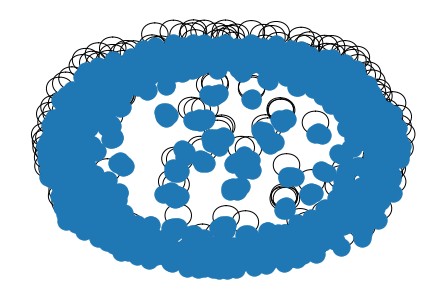

In [25]:
nx.draw(G);

In [273]:
df_rhymes['weight_example'] = 1
df_rhymes.dropna(inplace=True)
df_rhymes

C:\Users\Fuaad\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Fuaad\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,title,artist,word1,word2,rhyme_it_is,weight_example
0,Rap God,[Eminem],god,nod,True,1
0,Rap God,[Eminem],it,profit,True,1
0,Rap God,[Eminem],profit,it,True,1
0,Rap God,[Eminem],god,nod,True,1
0,Rap God,[Eminem],exuberance,nuisance,True,1
...,...,...,...,...,...,...
499,Arms Around You,"[XXXTENTACION, Lil Pump]",you,you,True,1
499,Arms Around You,"[XXXTENTACION, Lil Pump]",you,you,True,1
499,Arms Around You,"[XXXTENTACION, Lil Pump]",yeah,yeah,True,1
499,Arms Around You,"[XXXTENTACION, Lil Pump]",you,you,True,1


In [274]:
from pyvis.network import Network as net

got_net = net(notebook=True)

got_net = net(height='750px', width='100%', bgcolor='#222222', font_color='white')

# set the physics layout of the network
got_net.barnes_hut()
got_data = df_rhymes

sources = got_data['word1']
targets = got_data['word2']
weights = got_data['weight_example']

edge_data = zip(sources, targets, weights)

for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]

    got_net.add_node(src, src, title=src)
    got_net.add_node(dst, dst, title=dst)
    got_net.add_edge(src, dst, value=w)

neighbor_map = got_net.get_adj_list()

# add neighbor data to node hover data
for node in got_net.nodes:
    node['title'] += ' Neighbors:<br>' + '<br>'.join(neighbor_map[node['id']])
    node['value'] = len(neighbor_map[node['id']])

got_net.show('rhyme_network_v2.html')

# Adding weights

In [313]:
#Adding weights
df_rhymes_weighted = df_rhymes.groupby( [ "word1", "word2"] ).count().reset_index()
#df_rhymes_weighted ({'weight' : df_rhymes.groupby(['word1','word2']).weight_example.sum()}).reset_index()
df_rhymes_weighted

,word1,word2,title,artist,rhyme_it_is,weight_example
0,a,a,1,1,1,1
1,about,about,1,1,1,1
2,about,bout,1,1,1,1
3,about,out,2,2,2,2
4,abrasive,persuasive,1,1,1,1
...,...,...,...,...,...,...
1855,yourself,yourself,1,1,1,1
1856,yup,yup,1,1,1,1
1857,zone,own,2,2,2,2
1858,zone,trombone,1,1,1,1


In [353]:
df_rhymes_weighted_simple = df_rhymes_weighted.loc[~(df_rhymes_weighted['word1'] == df_rhymes_weighted['word2'])]
df_rhymes_weighted_simple.sort_values('title', ascending=False)[0:25]

,word1,word2,title,artist,rhyme_it_is,weight_example
127,bed,head,20,20,20,20
1705,turner,burner,11,11,11,11
250,chain,jane,10,10,10,10
69,around,down,10,10,10,10
804,it,shit,9,9,9,9
1397,shit,it,9,9,9,9
574,forces,crosses,8,8,8,8
1515,stank,dank,8,8,8,8
710,heart,apart,7,7,7,7
84,atlanta,fanta,7,7,7,7


In [350]:
df_rhymes_weighted_simple[df_rhymes_weighted_simple.word1 == 'fine']

,word1,word2,title,artist,rhyme_it_is,weight_example
542,fine,mine,3,3,3,3
543,fine,whine,1,1,1,1


In [314]:
got_net = net(notebook=True)

got_net = net(height='750px', width='100%', bgcolor='#222222', font_color='white')

# set the physics layout of the network
got_net.barnes_hut()
got_data = df_rhymes_weighted

sources = got_data['word1']
targets = got_data['word2']
weights = got_data['weight_example']

edge_data = zip(sources, targets, weights)

for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]

    got_net.add_node(src, src, title=src, size=w)
    got_net.add_node(dst, dst, title=dst, size=w)
    got_net.add_edge(src, dst, value=w)

neighbor_map = got_net.get_adj_list()

# add neighbor data to node hover data
for node in got_net.nodes:
    node['title'] += ' Neighbors:<br>' + '<br>'.join(neighbor_map[node['id']])
    node['value'] = len(neighbor_map[node['id']])

got_net.show('rhyme_network_weighted_v2.html')

# Trying Plotly for visualising interactive networks

In [328]:
import plotly.graph_objects as go
import chart_studio
import chart_studio.plotly as py
#I've removed my credentials from the below - swap in yours when trying this out
chart_studio.tools.set_credentials_file(username='', api_key='')

In [336]:
G = nx.from_pandas_edgelist(df_rhymes_weighted_simple, source='word1', target='word2',  edge_attr='weight_example')
#G = nx.random_geometric_graph(200, 0.125)

In [337]:
G.edges

EdgeView([('about', 'bout'), ('about', 'out'), ('bout', 'clout'), ('bout', 'out'), ('out', 'doubt'), ('out', 'drought'), ('out', 'route'), ('abrasive', 'persuasive'), ('accountants', 'parents'), ('accuse', 'brews'), ('ace', 'face'), ('face', 'bass'), ('face', 'case'), ('face', 'place'), ('face', 'replace'), ('addiction', 'listen'), ('addiction', 'vision'), ('addiction', 'definition'), ('listen', 'competition'), ('listen', 'vision'), ('vision', 'kitchen'), ('vision', 'mission'), ('adele', 'cell'), ('cell', 'hell'), ('adjust', 'bust'), ('adorable', 'rhetorical'), ('rhetorical', 'oracle'), ('adore', 'for'), ('for', 'c4'), ('for', 'more'), ('for', 'pour'), ('for', 'war'), ('advance', 'chance'), ('advance', 'dance'), ('chance', 'france'), ('advisory', 'ivory'), ('afraid', 'shade'), ('african', 'aryan'), ('african', 'justification'), ('again', 'pen'), ('pen', 'when'), ('age', 'rage'), ('agent', 'payment'), ('ago', 'go'), ('air', 'there'), ('there', 'care'), ('there', 'belair'), ('there', 'sh

[1,
 3,
 3,
 6,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 5,
 1,
 3,
 4,
 4,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 6,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 6,
 1,
 1,
 1,
 3,
 7,
 5,
 3,
 1,
 3,
 1,
 1,
 5,
 2,
 5,
 6,
 2,
 3,
 6,
 5,
 6,
 2,
 1,
 1,
 1,
 5,
 9,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 3,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 4,
 1,
 2,
 1,
 1,
 1,
 6,
 2,
 6,
 1,
 2,
 1,
 3,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 3,
 5,
 1,
 2,
 2,
 3,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 2,
 8,
 3,
 2,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 5,
 1,
 3,
 2,
 4,
 3,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 3,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 5,
 4,
 6,
 2,
 4,
 1,
 1,
 2,
 6,
 3,
 7,
 2,
 1,
 3,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 4,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 3,
 3,
 5,
 4,
 1,
 1,
 1,
 1,
 1,
 5,
 2,
 3,
 5,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,


In [338]:
G.nodes

NodeView(('about', 'bout', 'out', 'abrasive', 'persuasive', 'accountants', 'parents', 'accuse', 'brews', 'ace', 'face', 'addiction', 'listen', 'vision', 'adele', 'cell', 'adjust', 'bust', 'adorable', 'rhetorical', 'adore', 'for', 'advance', 'chance', 'advisory', 'ivory', 'afraid', 'shade', 'african', 'aryan', 'again', 'pen', 'age', 'rage', 'agent', 'payment', 'ago', 'go', 'air', 'there', 'aki', 'kawasaki', 'all', 'ball', 'call', 'hall', 'wall', 'allure', 'tour', 'alone', 'clone', 'own', 'phone', 'along', 'song', 'wrong', 'alright', 'right', 'anarchy', 'panicky', 'and', 'mind', 'weekend', 'anorexic', 'electric', 'anxious', 'service', 'anymore', 'ignore', 'anyway', 'hemingway', 'apart', 'start', 'appear', 'premiere', 'appearance', 'clearance', 'approval', 'removal', 'are', 'star', 'area', 'hysteria', 'armani', 'romney', 'around', 'demand', 'down', 'arrival', 'survival', 'arrive', 'survive', 'arrived', 'survived', 'aside', 'pride', 'ass', 'class', 'astonish', 'polish', 'astronomical', 're

In [339]:
pos_ = nx.spring_layout(G)

In [340]:
def make_edge(x, y, text, width):
    
    '''Creates a scatter trace for the edge between x's and y's with given width

    Parameters
    ----------
    x    : a tuple of the endpoints' x-coordinates in the form, tuple([x0, x1, None])
    
    y    : a tuple of the endpoints' y-coordinates in the form, tuple([y0, y1, None])
    
    width: the width of the line

    Returns
    -------
    An edge trace that goes between x0 and x1 with specified width.
    '''
    return  go.Scatter(x         = x,
                       y         = y,
                       line      = dict(width = width,
                                   color = 'white'),
                       hoverinfo = 'text',
                       text      = ([text]),
                       mode      = 'lines')

In [341]:
edge_trace = []
for edge in G.edges():
    
    if G.edges()[edge]['weight_example'] > 0:
        char_1 = edge[0]
        char_2 = edge[1]

        x0, y0 = pos_[char_1]
        x1, y1 = pos_[char_2]

        text   = char_1 + '--' + char_2 + ': ' + str(G.edges()[edge]['weight_example'])
        
        trace  = make_edge([x0, x1, None], [y0, y1, None], text,
                           0.3*G.edges()[edge]['weight_example']**1.75)

        edge_trace.append(trace)

In [342]:
# Make a node trace
node_trace = go.Scatter(
    x = [],
    y = [],
    mode='markers',
    hoverinfo='text',
    text = [],
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Viridis',
        reversescale=True,
        color=[],
        size=10,
          colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0.5, color='#888')))
# For each node in midsummer, get the position and size and add to the node_trace
for node in G.nodes():
    x, y = pos_[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    #node_trace['marker']['color'] += tuple(['cornflowerblue'])
    #node_trace['marker']['size'] = 10
    node_trace['text'] += tuple(['<b>' + node + '</b>'])

In [343]:
node_adjacencies = []
#node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    #node_text.append(G.nodes)

node_trace.marker.color = node_adjacencies
#node_trace.text = node_text

In [344]:
layout = go.Layout(#title='<br>Network graph made with Python',
                #titlefont_size=16,
                showlegend=False,
                hovermode='closest',
    plot_bgcolor='#1F1F1F',
    paper_bgcolor='#1F1F1F',
    xaxis =  {                                     
                                    'showgrid': False, 'zeroline': False, # thick line at x=0
    'visible': False,  # numbers below
                                         },
    yaxis = {                              
                                   'showgrid': False,     'zeroline': False, # thick line at x=0
    'visible': False,  # numbers below
                                        }
)


fig = go.Figure(layout = layout)

for trace in edge_trace:
    fig.add_trace(trace)

fig.add_trace(node_trace)

fig.update_layout(showlegend = False)

fig.update_xaxes(showticklabels = False)

fig.update_yaxes(showticklabels = False)

fig.show()


In [345]:
py.plot(fig, filename = 'rap_rhyme_network_interactive', auto_open=True)
# include_plotlyjs=False, full_html=False)

'https://plotly.com/~fuaadness/1/'